In [1]:
import numpy as np
import gymnasium as gym
import matplotlib 
#matplotlib.use('Qt5Agg') # Activte it if you want external plot for any interaction
import matplotlib.pyplot as plt
import time
from moviepy import ImageSequenceClip # to generate gif
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ----------------------------------------
# Create the Taxi environment in RGB mode
# ----------------------------------------
env = gym.make("Taxi-v3", render_mode="rgb_array")

In [3]:
# ----------------------------------------
# Get the raw environment to access .P transition dynamics
# ----------------------------------------
raw_env = env.unwrapped  # Needed for .P attribute

In [4]:
# ----------------------------------------
# State and Action Space Details
# ----------------------------------------
# Taxi-v3 environment details:
# - State space size: 500 discrete states
#   (Taxi position: 25 locations (5x5 grid) × passenger location: 5 × destination: 4)
# - Action space size: 6 discrete actions
#   (0: South, 1: North, 2: East, 3: West, 4: Pickup, 5: Dropoff)

n_states = env.observation_space.n  # 500 states
n_actions = env.action_space.n      # 6 actions

n_states , n_actions

(np.int64(500), np.int64(6))

In [5]:
# ----------------------------------------
# Initialize random policy and zero value function
# ----------------------------------------
policy = np.random.choice(n_actions, size=n_states)
V = np.zeros(n_states) # value function 

In [6]:
# ----------------------------------------
# Policy Evaluation Function
# ----------------------------------------
def policy_evaluation(policy, V, env, discount_factor=0.99, theta=1e-5):
    while True:
        delta = 0
        V_new = np.copy(V)
        for s in range(n_states):
            a = policy[s]
            v = 0
            for prob, next_state, reward, done in env.P[s][a]:
                v += prob * (reward + discount_factor * V[next_state])
            V_new[s] = v
            delta = max(delta, abs(V_new[s] - V[s]))
        V = V_new
        if delta < theta:
            break
    return V


In [7]:
# ----------------------------------------
# Policy Improvement Function
# ----------------------------------------
def policy_improvement(V, env, discount_factor=0.99):
    """
    Improve the policy given the current value function V.
    Return the improved policy and whether it is stable.
    """
    policy_stable = True
    new_policy = np.copy(policy)
    
    for s in range(n_states):
        action_values = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                action_values[a] += prob * (reward + discount_factor * V[next_state])
        best_action = np.argmax(action_values)
        if policy[s] != best_action:
            policy_stable = False
        new_policy[s] = best_action
    return new_policy, policy_stable

In [8]:
# ----------------------------------------
# Policy Iteration Algorithm with progress output
# ----------------------------------------
def policy_iteration(env, policy, V, max_iterations=1000,print_out_step=50):
    for iteration in range(1, max_iterations + 1):
        if((iteration+1)%print_out_step==0):
            print(f"\nPolicy Iteration: {iteration}")
        V = policy_evaluation(policy, V, env)
        policy, stable = policy_improvement(V, env)
        if((iteration+1)%print_out_step==0):
            print(f"Policy Improvement done. Policy stable: {stable}")
        if stable:
            print("Policy iteration converged!")
            return policy, V
    print("Policy iteration reached max iterations without convergence.")
    return policy, V


In [9]:
# -------------------------
# Render Policy Using RGB Frames
# -------------------------



def create_gif(frames, filename, fps=5):
    """Creates a GIF animation from a list of frames."""
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_gif(filename, fps=fps)
    
    
def run_multi_episodes(env, policy, num_episodes=3):
    total_frames = []
    total_reward = []
    total_steps = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        steps = 0
        while not done and steps < 50: # A good solution is obtained less than 50 actions
            # Capture the rendered frame
            frame = env.render()
            total_frames.append(frame)

            # Take action from learned policy
            action = policy[state]
            state, reward, done, truncated, info = env_vis.step(action)
            episode_reward += reward
            steps += 1
        total_reward.append(episode_reward)
        total_steps.append(steps)
    return total_frames, total_steps, total_reward



In [10]:
trained_policy, trained_V = policy_iteration(raw_env, policy, V)



Policy Iteration: 49
Policy Improvement done. Policy stable: False

Policy Iteration: 99
Policy Improvement done. Policy stable: False

Policy Iteration: 149
Policy Improvement done. Policy stable: False

Policy Iteration: 199
Policy Improvement done. Policy stable: False

Policy Iteration: 249
Policy Improvement done. Policy stable: False

Policy Iteration: 299
Policy Improvement done. Policy stable: False

Policy Iteration: 349
Policy Improvement done. Policy stable: False

Policy Iteration: 399
Policy Improvement done. Policy stable: False

Policy Iteration: 449
Policy Improvement done. Policy stable: False

Policy Iteration: 499
Policy Improvement done. Policy stable: False

Policy Iteration: 549
Policy Improvement done. Policy stable: False

Policy Iteration: 599
Policy Improvement done. Policy stable: False

Policy Iteration: 649
Policy Improvement done. Policy stable: False

Policy Iteration: 699
Policy Improvement done. Policy stable: False

Policy Iteration: 749
Policy Improv

In [11]:

env_vis = gym.make("Taxi-v3", render_mode="rgb_array")

total_frames, total_steps, total_reward = run_multi_episodes(env_vis, trained_policy, num_episodes=4)
print('pls wait, we are generating gif...')
# Decrease fps to see movement clearly.
create_gif(total_frames, f"Taxi-policy-iteration.gif", fps=2) 

print(f"\n\nThere are {len(total_steps)} episodes:\n")
for i,t in enumerate(zip(total_steps,total_reward)):
    print(f'    -- Epsiode {i}      length {t[0]}      return {t[1]}')

pls wait, we are generating gif...
MoviePy - Building file Taxi-policy-iteration.gif with imageio.




There are 4 episodes:

    -- Epsiode 0      length 17      return 4
    -- Epsiode 1      length 14      return 7
    -- Epsiode 2      length 13      return 8
    -- Epsiode 3      length 18      return 3


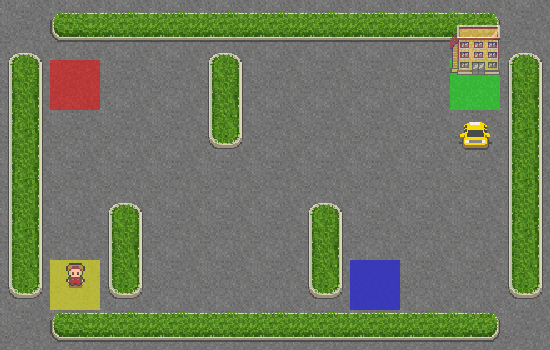

In [12]:
Image(filename='./Taxi-policy-iteration.gif')